#### Active learning NNGP experiment
We use one set of params for simple example

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

from model.mlp import MLP
from dataloader.rosen import RosenData
from uncertainty_estimator.nngp import NNGP
from sample_selector.eager import EagerSampleSelector
from oracle.identity import IdentityOracle


In [4]:
config = {
    'random_state': 4623457,
    'n_dim': 10,
    'n_train': 200,
    'n_test': 200,
    'n_pool': 1000,
    'layers': [128, 64, 32],
    'update_sample_size': 10,
    'al_iterations': 10
}

np.random.seed(config['random_state'])

In [5]:
def print_shapes(note, *sets):
    print(note)
    for x, y in sets:
        print("shapes:", x.shape, y.shape)

# load data
X_train, y_train, _, _, X_test, y_test, X_pool, y_pool = RosenData(
    config['n_train'], 0, config['n_test'], config['n_pool'], config['n_dim']
).dataset()

In [6]:
# Init neural network & tf session
tf.reset_default_graph()

model = MLP(
    ndim = config['n_dim'],
    random_state = config['random_state'],
    layers = config['layers']
)

try:
    sess.close()
except:
    pass
session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True

init = tf.global_variables_initializer()
sess = tf.Session(config=session_config)
sess.run(init)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [44]:
estimator = NNGP(model)  # to estimate uncertainties
oracle = IdentityOracle(y_pool)  # generate y for X from pool
sampler = EagerSampleSelector(oracle) # sample X and y from pool by uncertainty estimations

estimator.estimate(sess, X_train, y_train, X_pool)

array([0.        , 0.00742023, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00219058, 0.        , 0.        ,
       0.00603731, 0.        , 0.00509445, 0.        , 0.        ,
       0.00231341, 0.        , 0.00282036, 0.00510296, 0.00617693,
       0.00488377, 0.00154529, 0.00309945, 0.004882  , 0.        ,
       0.        , 0.        , 0.        , 0.00540273, 0.00697696,
       0.00264545, 0.        , 0.        , 0.00753367, 0.        ,
       0.        , 0.        , 0.        , 0.00224714, 0.00478362,
       0.00064051, 0.        , 0.00114898, 0.        , 0.00844913,
       0.00291686, 0.00408292, 0.        , 0.00486653, 0.00558084,
       0.00240489, 0.        , 0.00568766, 0.        , 0.        ,
       0.        , 0.00715222, 0.00380999, 0.        , 0.00254945,
       0.00344842, 0.00388168, 0.00598584, 0.00758747, 0.        ,
       0.0014556 , 0.        , 0.00849379, 0.00258676, 0.        ,
       0.00274633, 0.        , 0.00339727, 0.        , 0.00763

In [45]:
model.train(sess, X_train, y_train, X_test, y_test, X_test, y_test)

rmses = [np.sqrt(mse(model.predict(sess, data=X_test), y_test))]


for al_iteration in range(1, config['al_iterations']+1):
    note = f'[{al_iteration}] BEFORE:'
    print_shapes(note, (X_train, y_train), (X_test, y_test), (X_pool, y_pool))
    
    # update pool
    uncertainties = estimator.estimate(sess, X_train, y_train, X_pool)
    X_train, y_train, X_pool = sampler.update_sets(
        X_train, y_train, X_pool, uncertainties, config['update_sample_size']
    )
    
    note = f'[{al_iteration}] AFTER:'
    print_shapes(note, (X_train, y_train), (X_test, y_test), (X_pool, y_pool))
    
    # retrain net
    model.train(sess, X_train, y_train, X_test, y_test, X_test, y_test)
    rmses.append(np.sqrt(mse(model.predict(sess, data=X_test), y_test)))

[100] RMSE train:186.900 test:191.764 val:191.764 patience:3
[200] RMSE train:180.022 test:184.687 val:184.687 patience:3
[300] RMSE train:162.864 test:167.031 val:167.031 patience:3
[400] RMSE train:131.115 test:134.400 val:134.400 patience:3
[500] RMSE train:91.724 test:94.210 val:94.210 patience:3
[600] RMSE train:68.533 test:71.244 val:71.244 patience:3
[700] RMSE train:64.706 test:67.898 val:67.898 patience:3
[800] RMSE train:64.410 test:67.763 val:67.763 patience:3
[900] RMSE train:64.252 test:67.672 val:67.672 patience:3
[1000] RMSE train:64.087 test:67.564 val:67.564 patience:3
[1100] RMSE train:63.915 test:67.451 val:67.451 patience:3
[1200] RMSE train:63.736 test:67.334 val:67.334 patience:3
[1300] RMSE train:63.551 test:67.214 val:67.214 patience:3
[1400] RMSE train:63.361 test:67.090 val:67.090 patience:3
[1500] RMSE train:63.167 test:66.965 val:66.965 patience:3
[1600] RMSE train:62.969 test:66.837 val:66.837 patience:3
[1700] RMSE train:62.768 test:66.709 val:66.709 patie

[700] RMSE train:5.563 test:30.420 val:30.420 patience:3
[800] RMSE train:5.223 test:30.377 val:30.377 patience:3
[900] RMSE train:4.915 test:30.365 val:30.365 patience:3
[1000] RMSE train:4.626 test:30.365 val:30.365 patience:3
[1100] RMSE train:4.348 test:30.373 val:30.373 patience:2
[1200] RMSE train:4.079 test:30.411 val:30.411 patience:1
[1300] RMSE train:3.827 test:30.408 val:30.408 patience:0
No patience left at epoch 1300. Early stopping.
[5] BEFORE:
shapes: (240, 10) (240, 1)
shapes: (200, 10) (200, 1)
shapes: (960, 10) (1000, 1)
[5] AFTER:
shapes: (250, 10) (250, 1)
shapes: (200, 10) (200, 1)
shapes: (950, 10) (1000, 1)
[100] RMSE train:4.533 test:30.484 val:30.484 patience:3
[200] RMSE train:4.029 test:30.605 val:30.605 patience:2
[300] RMSE train:3.676 test:30.689 val:30.689 patience:1
[400] RMSE train:3.396 test:30.839 val:30.839 patience:0
No patience left at epoch 400. Early stopping.
[6] BEFORE:
shapes: (250, 10) (250, 1)
shapes: (200, 10) (200, 1)
shapes: (950, 10) (10

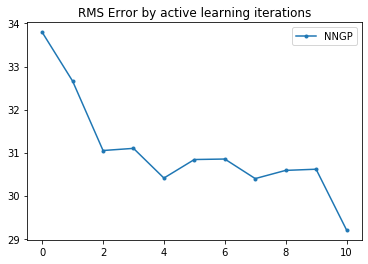

In [46]:
plt.plot(rmses, label='NNGP', marker='.')
plt.title('RMS Error by active learning iterations')
plt.legend()

In [16]:
# Show some predictions
print(model.predict(sess, data = X_test[:3]))
print(y_test[:3])

[[269.82272]
 [236.60335]
 [228.05836]]
[[269.35414184]
 [199.67728249]
 [197.7762695 ]]


In [27]:
# show some uncertainties
estimator.estimate(sess, X_pool)[:3]

array([160.86413073, 235.44600944, 191.88563576])